# Measurement Error Mitigation

This notebook is about quantum error mitigation in qiskit.

1. We are going to build a noise model using the noisy simulator model in qiskit.

2. We are going to take the outputs of the noisy model and demo9nstrate error mitigation.


In [1]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import qasm_simulator
import numpy as np

In [2]:
# importing qiskit's noise model class and pauli error class
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

# creating an instance of NoiseModel class
my_noise_model = NoiseModel()

#  In order to inject error into our circuit(s) to demonstrate error mitigation, we use pauli error
# with probability. Higher the probability, higher is the noise
#  this means that is has a  3 percent probability of flipping a bit
#  we can also add other gates for pauli error
prob = 0.03
error_pauli = pauli_error([('X', prob), ('I', 1-prob)]) 

# add the pauli error instance to all the qubits and we specify measurement error (in quotes) 
# at the time of measurement
my_noise_model.add_all_qubit_quantum_error(error_pauli, "measure")

# use help function to see the documentation of a class
# help(noise_model)





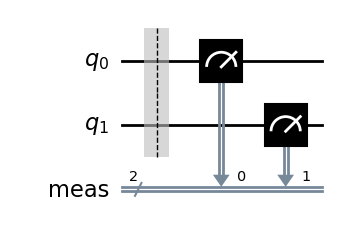

In [3]:
#  building a quantum circuit of 2 qubits and 2 bits
n_qubits = 2
n_bits = 2
qc = QuantumCircuit(n_qubits)
qc.measure_all()

qc.draw('mpl')

{'01': 31, '10': 25, '00': 944}


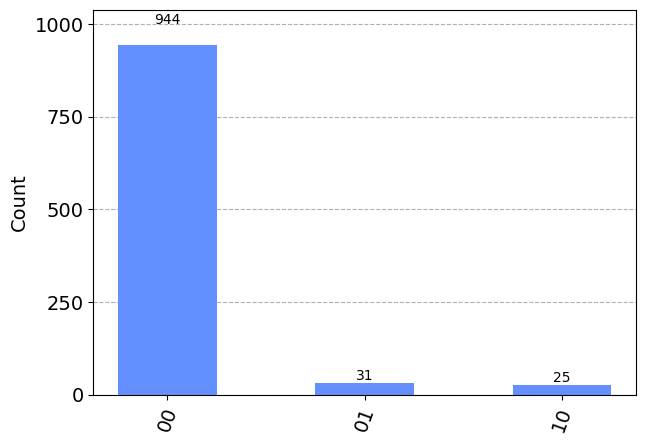

In [4]:
#  executing the quantum circuit
my_backend = Aer.get_backend('aer_simulator')


#  We can also mimick a noisy quantum computer throug the noise_model
counts_noisy = execute(qc, backend=my_backend, shots = 1000, noise_model=my_noise_model).result().get_counts()

# Since it is a bit flip error, we see that there will be a very low probability for flipping two 
# bits with the same value such as 00 or 11 compared with the probability for 01 and 10
print(counts_noisy)
plot_histogram(counts_noisy)

In [6]:
# Lets create a list of possible states for 2 qubits and create quantum circuits
two_qubit_states = ['00', '01', '10', '11']
my_backend = Aer.get_backend('aer_simulator')
my_shots = 1e4

# now let us create a quantum circuits for each of the states and see the counts
# since qiskit follows little endian for qubit order we will follow little endian
for state in two_qubit_states:
    noisy_qc = QuantumCircuit(len(two_qubit_states[0]))
    if state[0]=='1':
        noisy_qc.x(1)
    elif state[1] =='1':
        noisy_qc.x(0)
    noisy_qc.measure_all()
    counts = execute(noisy_qc, backend=my_backend, shots = my_shots, noise_model=my_noise_model).result().get_counts()

    print("Pure State: "+ state+ " ,turns into: ", counts)        


Pure State: 00 ,turns into:  {'01': 279, '11': 9, '10': 304, '00': 9408}
Pure State: 01 ,turns into:  {'10': 6, '00': 316, '11': 316, '01': 9362}
Pure State: 10 ,turns into:  {'01': 9, '11': 305, '00': 279, '10': 9407}
Pure State: 11 ,turns into:  {'01': 8, '00': 288, '11': 276, '10': 9428}


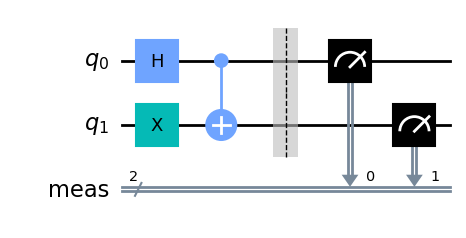

{'00': 40, '11': 33, '10': 461, '01': 466}
Noise free output is |01> + |10>, but actual output is  {'00': 40, '11': 33, '10': 461, '01': 466}


In [7]:
# Lets look at an example for one of the bell states, that is psi plus state whose output is 01 + 10
noisy_qc = QuantumCircuit(2)
noisy_qc.h(0)
noisy_qc.x(1)
noisy_qc.cx(0,1)

noisy_qc.measure_all()
display(noisy_qc.draw('mpl'))

my_backend = Aer.get_backend('aer_simulator')
noisy_results = execute(noisy_qc, backend=my_backend, shots = 1000, noise_model=my_noise_model).result()
counts = noisy_results.get_counts()
print(counts)
print("Noise free output is |01> + |10>, but actual output is ", counts)
plot_histogram(counts)



In [15]:
# Now let us import mitigation module from qiskit ignis to mitigate the errors

# this method generates individual circuits for each of the basis states generated out of two qubits 

from qiskit import *
# Measurement error mitigation functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
n_bits = 2
n_qubits = 2
my_qr = QuantumRegister(n_bits)
# help(complete_meas_cal)
my_qubit_list = list(range(n_qubits))

""""Return a list of measurement calibration circuits for the full Hilbert space. If the circuit 
contains :math:`n` qubits, then :math:`2^n` calibration circuits are created, each 
of which creates a basis state. Returns a list of QuantumCircuit objects containing the calibration circuits and 
a list of calibration state labels."""
# meas_calibs, state_labels = complete_meas_cal(qr=my_qr, circlabel = 'meas_cal')
meas_calibs_circuits, state_labels = complete_meas_cal(qubit_list=my_qubit_list, circlabel = 'meas_cal_circuit ')

print(state_labels)

['00', '01', '10', '11']


Quantum circuit  meas_cal_circuit cal_00


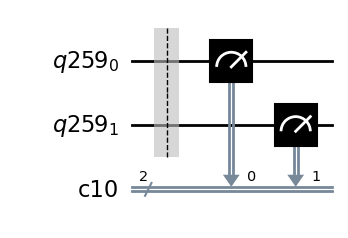

Quantum circuit  meas_cal_circuit cal_01


Quantum circuit  meas_cal_circuit cal_10


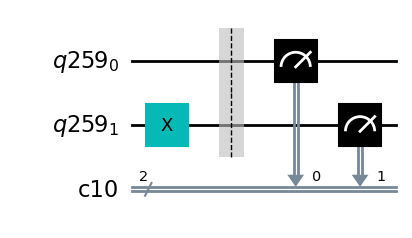

Quantum circuit  meas_cal_circuit cal_11


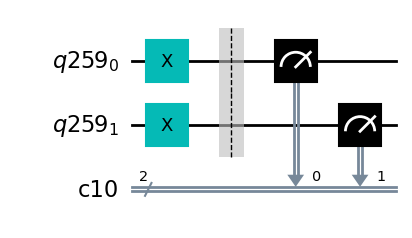

In [115]:
# displays the whole range of 2^n states and its quantum circcuits, with n being 
# number of qubits 
for q_circuit in meas_calibs_circuits:
    print("Quantum circuit ",q_circuit.name)
    display(q_circuit.draw('mpl'))

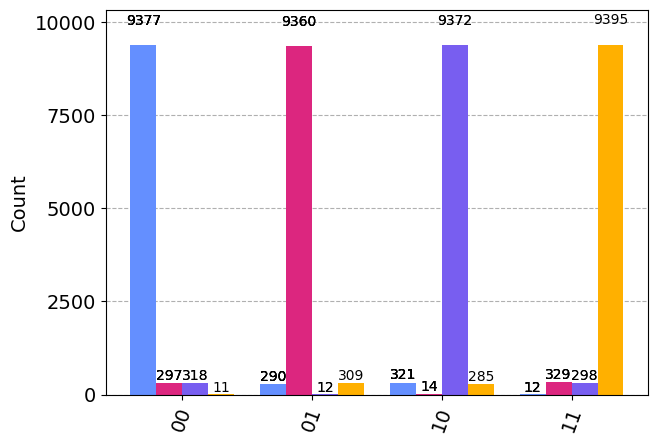

In [19]:
# we are transpiling the list of circuits in meas_calibs_circuits from previous step

from qiskit import *
# help(transpile)
my_backend = Aer.get_backend('aer_simulator')
# transpiling the circuits and then executing them
transpile_qc = transpile(meas_calibs_circuits, backend=my_backend)
calib_results = execute(transpile_qc, backend = my_backend, noise_model=my_noise_model, shots = 1e4).result()
calib_counts = calib_results.get_counts()
plot_histogram(calib_counts)


In [20]:
calib_counts

[{'01': 290, '11': 12, '10': 321, '00': 9377},
 {'10': 14, '00': 297, '11': 329, '01': 9360},
 {'01': 12, '00': 318, '11': 298, '10': 9372},
 {'01': 309, '00': 11, '10': 285, '11': 9395}]

In [154]:
#now want to compare the results from noisy output and error mitigated output

meas_fitter = CompleteMeasFitter(calib_results, state_labels, circlabel='meas_cal_circuit ')
meas_filter = meas_fitter.filter

# check results after error mitigated

mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()

# We see that the noise has gone down a lot after error mitigation
# and we see very high frequency for the psi plus bell states |01> + |10>
plot_histogram([counts ,mitigated_counts])



# We can repeat the same experiment done above using a circuit with some standard algorithm and mitigate the results from actual quantum computer